In [1]:
# Import packages
import os
import optuna
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_nodes = 3
study_name = f"dcl_sin_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
# 表示設定
trial_state = "RUNNING"  # または "RUNNING"
rankdir = "TB"  # "TB" = 縦, "LR" = 横

storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_671253/1330960720.py:8: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2025-08-25 10:28:57,096] Using an existing study with name 'dcl_sin_3' instead of creating a new one.


In [3]:
def get_sorted_trials(study, state):
    df = study.trials_dataframe()
    df = df[df.state == state]
    return df.sort_values(by="value", ascending=False)


sorted_df = get_sorted_trials(study, trial_state)

In [4]:
def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)


def get_model_names_for_trial(top_series, num_nodes):
    trial_dir = f"runs/{study_name}/{top_series.number:04}"
    model_names = [""] * num_nodes
    try:
        subdirs = sorted(os.listdir(trial_dir))
    except FileNotFoundError:
        subdirs = []
    for name in subdirs:
        if "_" not in name:
            continue
        prefix, model = name.split("_", 1)
        if prefix.isdigit():
            idx = int(prefix)
            if 0 <= idx < num_nodes:
                model_names[idx] = model
    # 補完: ノード1以降はOptunaのパラメータからも取得を試みる
    for i in range(1, num_nodes):
        if not model_names[i]:
            param_key = f"params_{i}_model"
            if param_key in top_series and isinstance(top_series[param_key], str):
                model_names[i] = top_series[param_key]
    # ノード0が未確定ならプレースホルダ
    if not model_names[0]:
        model_names[0] = "model0"
    return model_names


def get_node_label(top_series, model_id, model_names):
    # KTG CIFAR-100 dcl-sin-train.py の SummaryWriter パスに合わせる
    # runs/dcl_sin_{num_nodes}/{trial:04}/{i}_{model}
    node_label = f"{model_id+1}. {model_names[model_id]}"
    try:
        accumulator = EventAccumulator(
            f"runs/{study_name}/{top_series.number:04}/{model_id}_{model_names[model_id]}/"
        )
        accumulator.Reload()
        best_value = None
        try:
            scalar_tags = set(accumulator.Tags().get("scalars", []))
        except Exception:
            scalar_tags = set()
        # test_score のみを参照
        if "test_score" in scalar_tags:
            _, _, values = extract_scalar_arrays(accumulator.Scalars("test_score"))
            if len(values) > 0:
                best_value = max(values)
        if best_value is not None:
            node_label += f"\n{best_value:.2f}%"
    except Exception:
        pass
    return node_label


def format_sin_label(top_series, i, j):
    num_cycles_key = f"params_{i}_{j}_num_cycles"
    phase_key = f"params_{i}_{j}_phase"
    num_cycles = None
    phase = None
    try:
        if num_cycles_key in top_series:
            num_cycles = float(top_series[num_cycles_key])
    except Exception:
        num_cycles = None
    try:
        if phase_key in top_series:
            phase = float(top_series[phase_key])
    except Exception:
        phase = None
    parts = []
    if num_cycles is not None:
        parts.append(f"c={num_cycles:.2f}")
    if phase is not None:
        parts.append(f"φ={phase:.2f}")
    return "Sin(" + ", ".join(parts) + ")" if parts else "Sin"


def create_graph_for_trial(top_series, num_nodes, rankdir="LR", max_epoch=200, embed_edge_previews=True):
    model_names = get_model_names_for_trial(top_series, num_nodes)

    # プレビュー画像の保存先
    try:
        trial_no = int(top_series.number)
    except Exception:
        trial_no = -1
    preview_dir = os.path.abspath(os.path.join("runs", study_name, f"{trial_no:04}", "_sin_previews"))
    try:
        os.makedirs(preview_dir, exist_ok=True)
    except Exception:
        pass

    def render_sin_preview(i, j):
        # 画像を生成してパスを返す
        filename = f"{i}_{j}.png"
        path = os.path.join(preview_dir, filename)
        if not os.path.exists(path):
            num_cycles_key = f"params_{i}_{j}_num_cycles"
            phase_key = f"params_{i}_{j}_phase"
            if num_cycles_key in top_series and phase_key in top_series:
                try:
                    num_cycles = float(top_series[num_cycles_key])
                    phase = float(top_series[phase_key])
                    t = np.linspace(0.0, 1.0, max(2, int(max_epoch)))
                    amplitude = 0.5
                    bias = 0.5
                    w = bias + amplitude * np.sin(2.0 * np.pi * num_cycles * t + phase)
                    fig, ax = plt.subplots(figsize=(1.2, 0.6))
                    ax.plot(t, w, color=(0.9, 0.4, 0.0), linewidth=1.5)
                    ax.set_ylim(-0.1, 1.1)
                    ax.set_xlim(0.0, 1.0)
                    ax.axis("off")
                    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
                    fig.savefig(path, dpi=120, transparent=True)
                    plt.close(fig)
                except Exception:
                    return None
            else:
                return None
        return path

    def build_edge_label(i, j):
        edge_text = format_sin_label(top_series, i, j)
        if not embed_edge_previews:
            return edge_text
        img_path = render_sin_preview(i, j)
        if img_path is None:
            return edge_text
        html = (
            f"<TABLE BORDER=\"0\" CELLBORDER=\"0\" CELLPADDING=\"2\">"
            f"<TR><TD><FONT POINT-SIZE=\"12\">{edge_text}</FONT></TD></TR>"
            f"<TR><TD><IMG SRC=\"{img_path}\" SCALE=\"TRUE\"/></TD></TR>"
            f"</TABLE>"
        )
        return f"<{html}>"

    graph = Digraph(format="svg")
    graph.attr(rankdir=rankdir)

    # ラベル（教師信号）ノード
    label_node_id = "label"
    label_display = "Label"
    graph.node(label_node_id, label=label_display, shape="plaintext", fontcolor="black")

    for i in range(num_nodes):
        node_color = "pink" if i == 0 else "gray90"
        node_id = f"node_{i}"
        node_label = get_node_label(top_series, i, model_names)
        graph.node(
            node_id,
            label=node_label,
            color=node_color,
            fillcolor=node_color,
            style="filled",
        )

        # エッジ（教師信号: Label -> i）。SinGate のパラメータとプレビュー
        label_text = build_edge_label(i, i)
        graph.edge(
            label_node_id,
            node_id,
            label=label_text,
            fontsize="13",
            color="darkorange",
        )

        # エッジ（j -> i）。SinGate のパラメータとプレビュー
        for j in range(num_nodes):
            if j == i:
                continue
            neighbor_node_id = f"node_{j}"
            edge_label = build_edge_label(i, j)
            graph.edge(
                neighbor_node_id,
                node_id,
                label=edge_label,
                fontsize="13",
                color="darkorange",
            )
            
    return graph
            

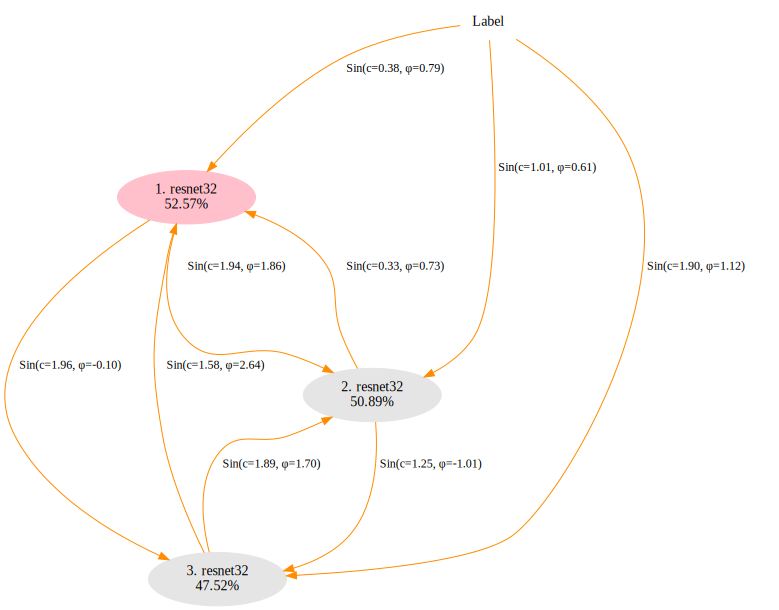

In [6]:
top = 1
if len(sorted_df) == 0:
    raise ValueError(f"No trials with state={trial_state}")
G = create_graph_for_trial(sorted_df.iloc[top], num_nodes, rankdir=rankdir)
display(G)